<h3>    Target:   </h3>
<h6> Get the set-up right   </h6> 
<h6>Set Transforms   </h6> 
<h6>Set Data Loader   </h6> 
<h6>Set Basic Working Code with the model lighter as much as possible  </h6>  
<h6>Set Basic Training & Test Loop  </h6>  
<h6>Add Batch-norm to increase model efficiency.   </h6>
<h3>    Results: </h3>
<h6>Parameters: 10,970  </h6>
<h6>Best Train Accuracy: 99.87  </h6>
<h6>Best Test Accuracy:  99.34 (11th Epoch), 99.26 (20th Epoch)  </h6>
<h3>    Analysis: </h3>
<h6>We have done the setup for training the model.  </h6>
<h6>A basic model with no fancy stuff except batchnorm is considered   </h6> 
<h6>This model wont able to reach a test accuracy of 99.4</h6>
        


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# CODE BLOCK 1
### import neccessary packages for training the mnist model

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [3]:
# import custom modules
%cd '/content/gdrive/MyDrive/ERA2/session7/'
import model

/content/gdrive/MyDrive/ERA2/session7


# Data Transformations

#### We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


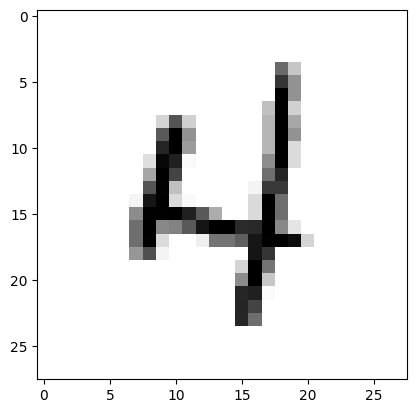

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

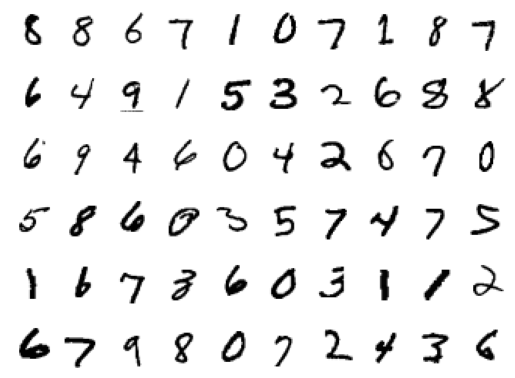

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model 1
Let's start with the model we first saw

In [9]:
# Model summary
use_cuda = torch.cuda.is_available()
# set the device to run the program in cpu or gpu
device = torch.device("cuda" if use_cuda else "cpu")
# load neural network model from custom module (model)
# Main method of the program
Model_1 = model.Model_1().to(device)
summary(Model_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-1, 1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model 1

In [11]:
model_1 =  model.Model_1().to(device)
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_1, device, train_loader, optimizer, epoch)
    test(model_1, device, test_loader)

EPOCH: 0


Loss=0.07525639981031418 Batch_id=468 Accuracy=94.47: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]



Test set: Average loss: 0.0612, Accuracy: 9801/10000 (98.01%)

EPOCH: 1


Loss=0.04043886810541153 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]



Test set: Average loss: 0.0370, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.04990250989794731 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]



Test set: Average loss: 0.0343, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.013455335050821304 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 23.45it/s]



Test set: Average loss: 0.0316, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.017203809693455696 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0326, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.02756272815167904 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0278, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.020215390250086784 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]



Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.023532522842288017 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]



Test set: Average loss: 0.0253, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.009517258033156395 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.0296, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.0022736098617315292 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.030646726489067078 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.058497220277786255 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.02612638659775257 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0233, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.02947104722261429 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:17<00:00, 26.58it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.00511201610788703 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.016260070726275444 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]



Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.0008627723436802626 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH: 17


Loss=0.0006072383257560432 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]



Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.001074492116458714 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]



Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.0021012721117585897 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Test Accuracy')

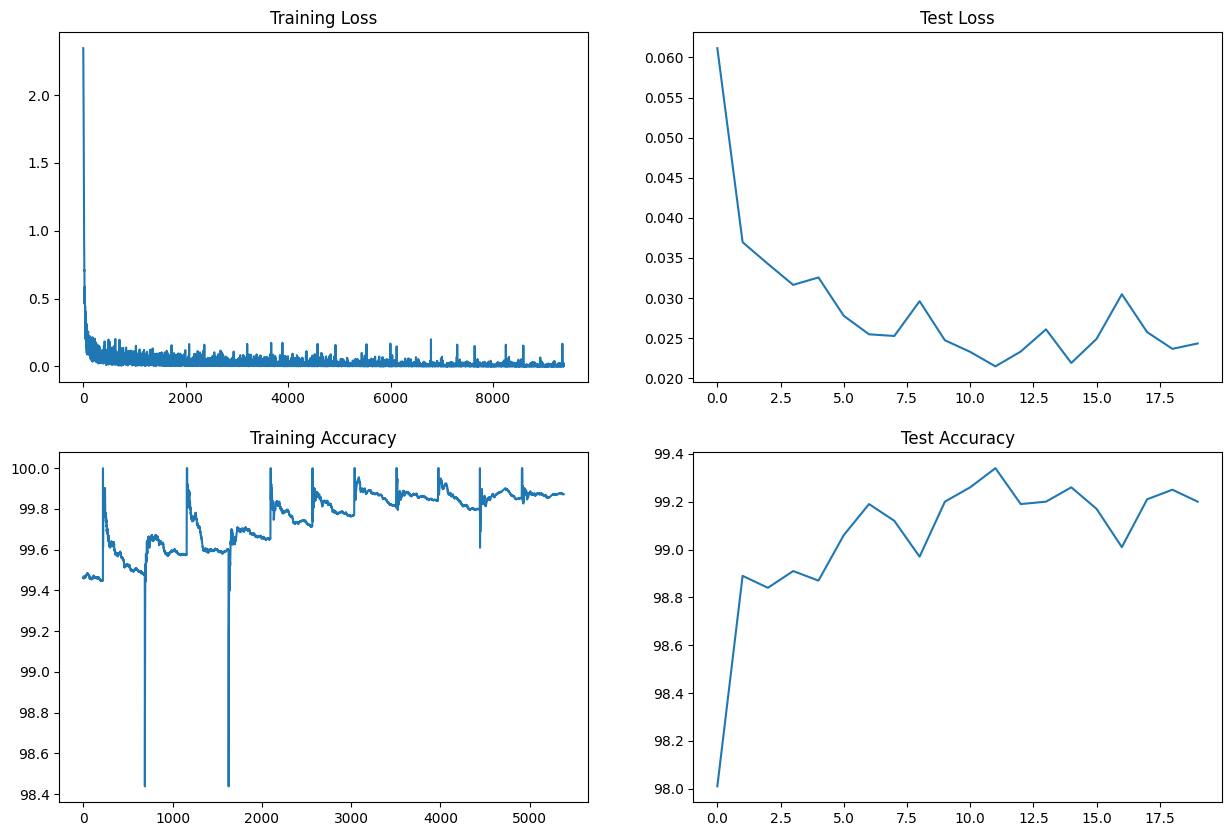

In [12]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")